# NammaMetro Ridership EDA

In [423]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

### Let's take a closer look at what NammaMetro has been dishing out so far

In [424]:
filename = "NammaMetro_Ridership_Dataset.csv"
df = pd.read_csv(filename, index_col=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38 entries, 0 to 37
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Record Date        38 non-null     object
 1   Total Smart Cards  38 non-null     int64 
 2   Stored Value Card  38 non-null     int64 
 3   One Day Pass       38 non-null     int64 
 4   Three Day Pass     38 non-null     int64 
 5   Five Day Pass      38 non-null     int64 
 6   Tokens             38 non-null     int64 
 7   Total NCMC         38 non-null     int64 
 8   Group Ticket       38 non-null     int64 
 9   Total QR           38 non-null     int64 
 10  QR NammaMetro      38 non-null     int64 
 11  QR WhatsApp        38 non-null     int64 
 12  QR Paytm           38 non-null     int64 
dtypes: int64(12), object(1)
memory usage: 4.2+ KB


In [425]:
df.tail(10)

,Record Date,Total Smart Cards,Stored Value Card,One Day Pass,Three Day Pass,Five Day Pass,Tokens,Total NCMC,Group Ticket,Total QR,QR NammaMetro,QR WhatsApp,QR Paytm
28,29-11-2024,459914,458983,644,77,210,205777,11220,780,181937,50383,97180,34374
29,30-11-2024,391894,390520,1180,142,52,234756,8428,1045,178402,47520,97787,33095
30,01-12-2024,154334,153369,816,110,39,220404,4122,600,196242,52072,107955,36215
31,02-12-2024,409724,409132,340,90,162,187408,10402,872,177203,50580,93367,33256
32,03-12-2024,461996,461278,429,95,194,198932,12319,325,155053,51715,65741,37597
33,04-12-2024,491111,490387,413,200,111,205660,13014,896,190794,54771,97885,38138
34,05-12-2024,478727,477989,458,79,201,211363,12739,443,197958,56163,102339,39456
35,06-12-2024,415499,414771,411,93,224,225172,12081,219,117316,1081,102925,46269
36,07-12-2024,345932,344657,1100,80,95,268704,8885,852,258927,69323,140034,49570
37,08-12-2024,183305,182088,1108,50,59,290250,4875,590,238955,63957,131212,43786


The [Namma Metro Ridership stats page](https://english.bmrc.co.in/ridership/) publishes a breakdown of payment methods used daily by passengers entering the system.
![ridership_plot](nammametro_datapage.png)

In [426]:
df['Total Riders'] = df.loc[:, ['Total Smart Cards', 'Tokens', 'Total NCMC', 'Group Ticket', 'Total QR']].sum(axis=1)
df['Record Date'] = pd.to_datetime(df['Record Date'], format='%d-%m-%Y')
df['Day of Week'] = df['Record Date'].dt.day_name()

df[['Record Date', 'Day of Week', 'Total Riders']].tail(7)


,Record Date,Day of Week,Total Riders
31,2024-12-02,Monday,785609
32,2024-12-03,Tuesday,828625
33,2024-12-04,Wednesday,901475
34,2024-12-05,Thursday,901230
35,2024-12-06,Friday,770287
36,2024-12-07,Saturday,883300
37,2024-12-08,Sunday,717975


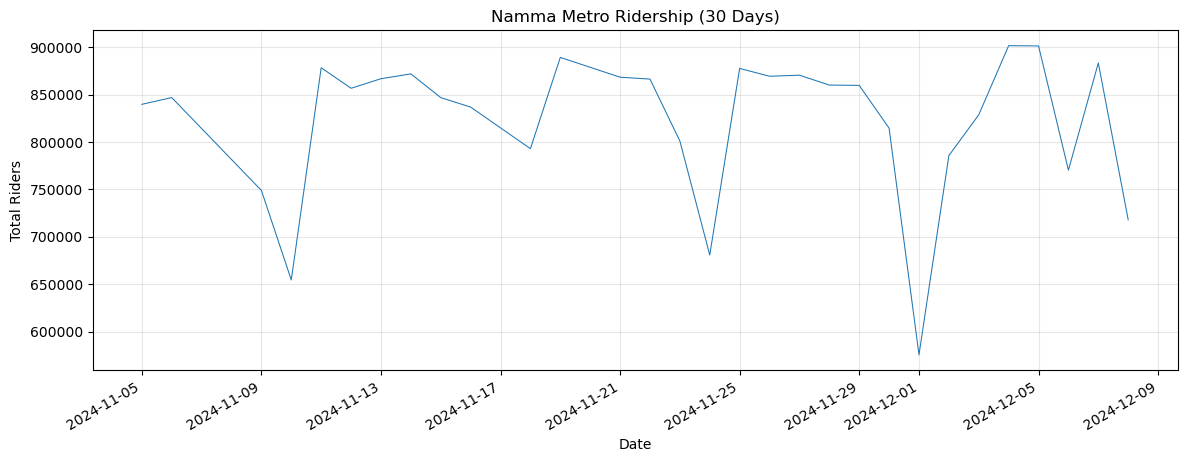

In [427]:
df.tail(30).plot(figsize=(14,5), 
                    kind='line', 
                    x='Record Date', 
                    xlabel='Date', 
                    y='Total Riders', 
                    ylabel='Total Riders', 
                    title='Namma Metro Ridership (30 Days)', 
                    legend=False,
                    linestyle='-',  # Solid line
                    linewidth=0.75)  # Thicker line
plt.grid(True, alpha=0.3)  # Optional: adds a light grid
plt.show()

### Let's make a cleaner graph for the last N days of available data.

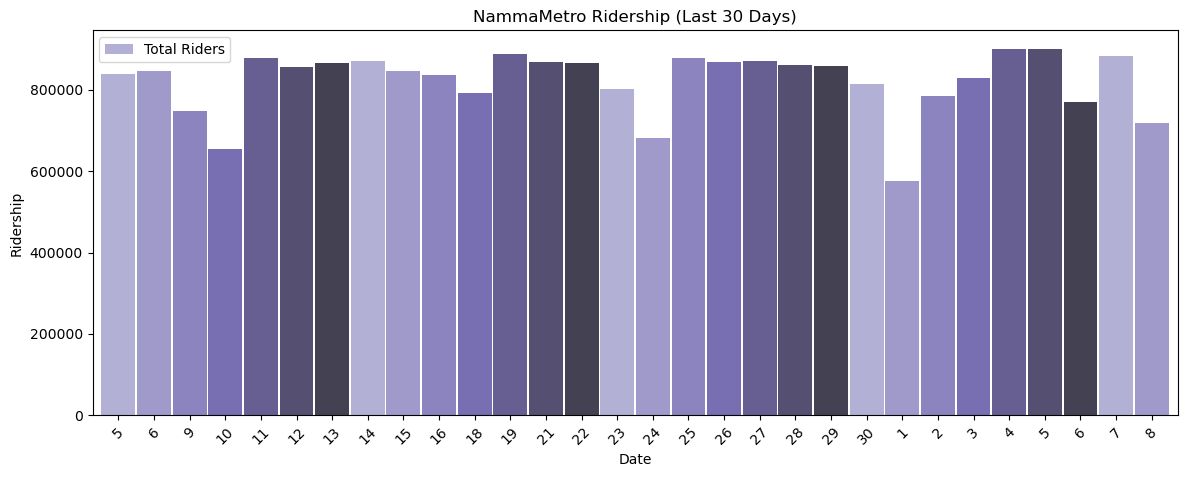

In [428]:
number_of_days = 30
Last_N_Days = df[['Record Date', 'Total Riders']].tail(number_of_days)
Last_N_Days['Record Date'] = pd.to_datetime(Last_N_Days['Record Date'], format='%d-%m-%Y').dt.day
Last_N_Days.plot(x='Record Date', 
                 y='Total Riders', 
                 kind='bar', 
                 xlabel='Date', 
                 ylabel='Ridership', 
                 title='NammaMetro Ridership (Last 30 Days)', 
                 figsize=(14,5), 
                 width=0.95,
                 legend=True,
                 color=sns.color_palette('Purples_d', 7),
                 rot=45)
plt.show()

### Note the gaps in the data. 
NammaMetro fails to report ridership numbers on some days. Is someone updating the page manually?! 
Let's get a better understanding of that missing data.

In [429]:
from datetime import date, timedelta

start_date = date.today() - timedelta(number_of_days, 0, 0)
dates = pd.DataFrame({'Record Date': [str(start_date+timedelta(n)) for n in range(number_of_days)]})
dates['Record Date'] = pd.to_datetime(dates['Record Date'], format='%Y-%m-%d')

print(f"We will examine data for an interval of {number_of_days} days between {dates['Record Date'].min().strftime('%d-%m-%Y')} and {dates['Record Date'].max().strftime('%d-%m-%Y')}.")

We will examine data for an interval of 30 days between 09-11-2024 and 08-12-2024.


In [430]:
# Merge the original df with the column of dates to get all values including nulls

Last_N_Days = df.merge(dates, how='right', on='Record Date')
Last_N_Days.drop(['Stored Value Card', 'One Day Pass', 'Three Day Pass', 'Five Day Pass', 'QR NammaMetro', 'QR WhatsApp', 'QR Paytm'], axis=1, inplace=True)
Last_N_Days.rename(columns={'Total Smart Cards':'Smart Cards', 'Total NCMC':'NCMC', 'Total QR':'QR'}, inplace=True)

formatted_dates = pd.to_datetime(Last_N_Days['Record Date'], format='%Y-%m-%d').dt.strftime('%d')
formatted_numbers = Last_N_Days.loc[:, 'Smart Cards':'Total Riders'].astype('Int64')

Last_N_Days_1 = pd.concat([formatted_dates, formatted_numbers, Last_N_Days['Day of Week']], axis=1)
Last_N_Days_1

,Record Date,Smart Cards,Tokens,NCMC,Group Ticket,QR,Total Riders,Day of Week
0,09,324351,242952,3145,477,177960,748885,Saturday
1,10,175159,262652,4351,805,211556,654523,Sunday
2,11,464358,218340,11685,964,182878,878225,Monday
3,12,475075,193049,12160,605,175699,856588,Tuesday
4,13,472363,204021,12056,1090,177117,866647,Wednesday
5,14,471099,207693,11858,348,180760,871758,Thursday
6,15,444111,211495,10644,413,180093,846756,Friday
7,16,331695,263563,8092,1311,232090,836751,Saturday
8,17,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaN
9,18,363367,231636,8835,833,188268,792939,Monday


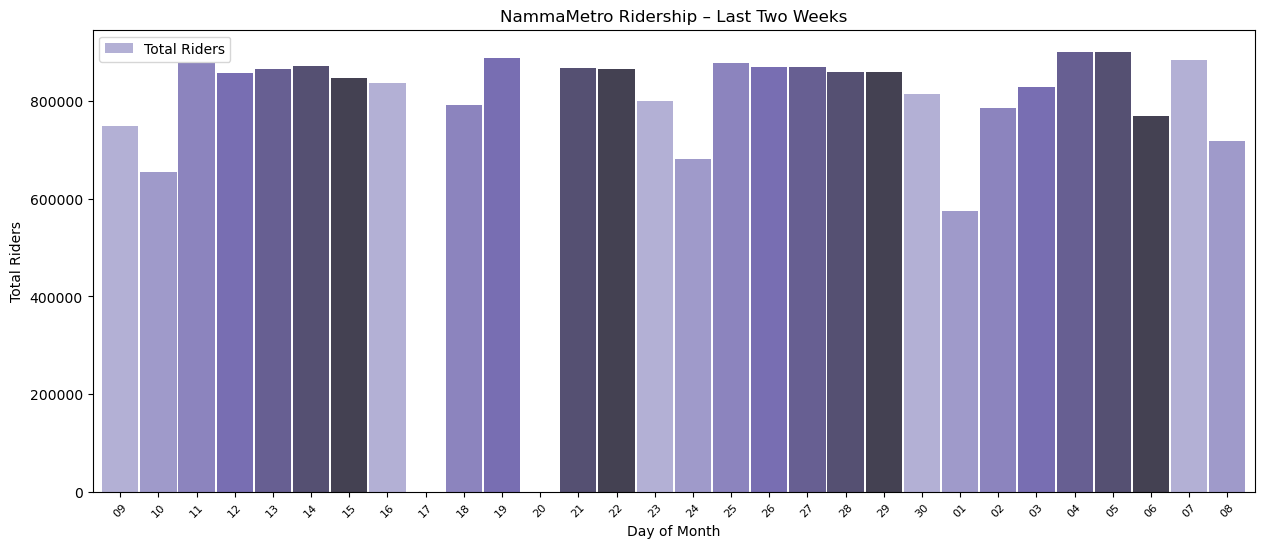

In [431]:
Last_N_Days_1.plot(x='Record Date',
                 y='Total Riders',
                 kind='bar',
                 xlabel='Day of Month',
                 ylabel='Total Riders',
                 title='NammaMetro Ridership – Last Two Weeks', 
                 figsize=(15,6),
                 width=0.95,
                 color=sns.color_palette('Purples_d', 7),
                 legend=True,
                 rot=45)
plt.xticks(fontsize=8)
plt.yticks(fontsize=10)
plt.show()

### Looks like a mouth with a few broken teeth!

What sort of data imputations makes sense here? When the dataset grows large enough over several months, I would fill unreported dates with an average of similar days, e.g. If a weekday Tuesday was missing, take the average of the last 4 available weekday Tuesdays.

In [432]:
Last_N_Days_2 = Last_N_Days.melt(
                    id_vars=['Record Date'], 
                    value_vars=['Smart Cards', 'Tokens', 'NCMC', 'Group Ticket', 'QR'], 
                    var_name='Access System', 
                    value_name='Count').sort_values(by=['Record Date', 'Access System'])
Last_N_Days_2 = Last_N_Days_2[['Record Date', 'Access System', 'Count']].sort_values(by=['Record Date', 'Access System'], ignore_index=True)

formatted_dates = pd.to_datetime(Last_N_Days_2['Record Date'], format='%Y-%m-%d').dt.strftime('%d')
formatted_numbers = Last_N_Days_2.loc[:, 'Count'].astype('Int64')

Last_N_Days_2 = pd.concat([formatted_dates, Last_N_Days_2['Access System'], formatted_numbers], axis=1)
Last_N_Days_2

,Record Date,Access System,Count
0,09,Group Ticket,477
1,09,NCMC,3145
2,09,QR,177960
3,09,Smart Cards,324351
4,09,Tokens,242952
...,...,...,...
145,08,Group Ticket,590
146,08,NCMC,4875
147,08,QR,238955
148,08,Smart Cards,183305


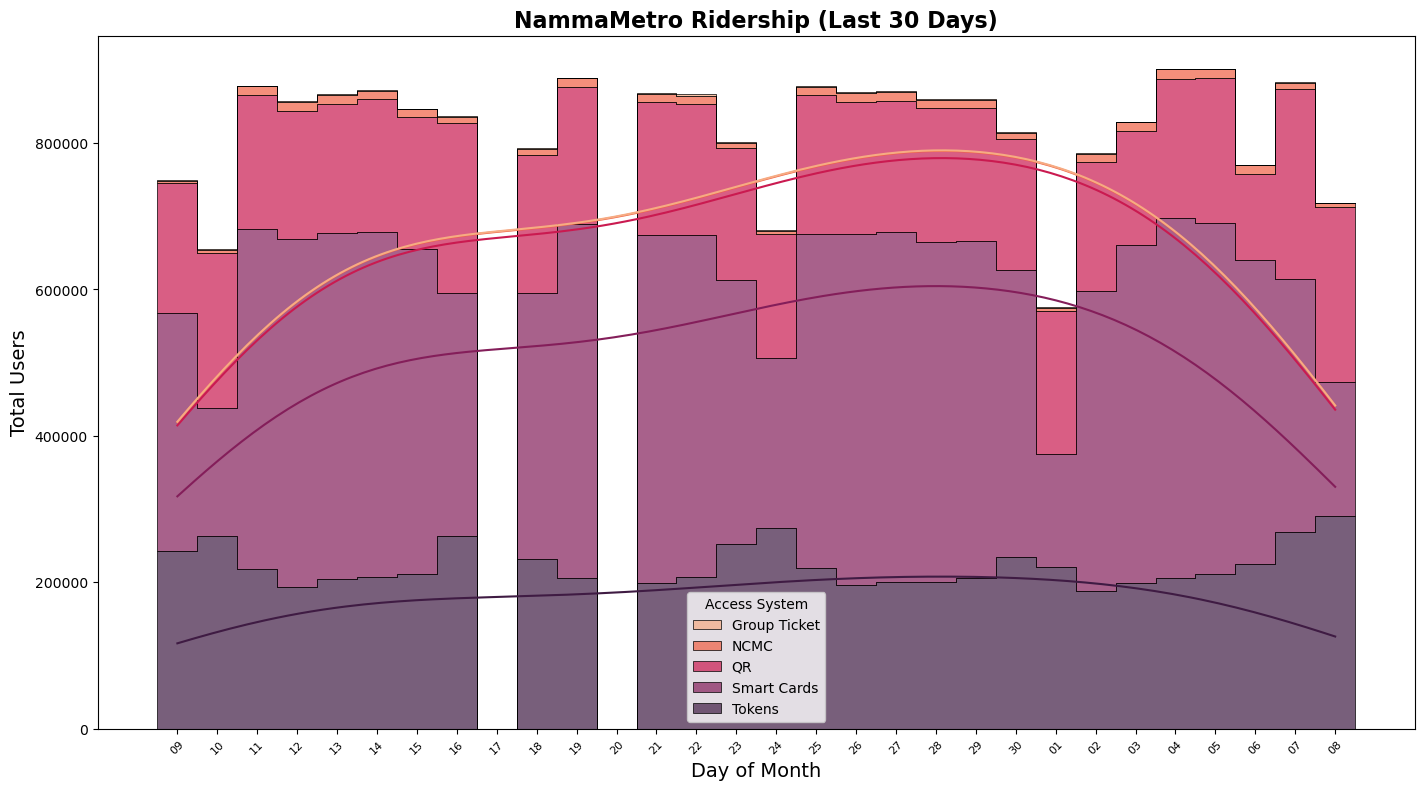

In [437]:
plt.figure(figsize=(17,9))
sns.histplot(data=Last_N_Days_2,
             x='Record Date',
             weights='Count',
             bins=number_of_days,
             hue='Access System',
             multiple='stack', 
             element='step',
             palette='rocket_r',
             legend=True, 
             common_norm=True,
             stat='count',
             linewidth=0.5,
             alpha=0.7, discrete=True, kde=True)
plt.xlabel('Day of Month', fontsize=14)
plt.ylabel('Total Users', fontsize=14)
plt.title(f'NammaMetro Ridership (Last {number_of_days} Days)', fontsize=16, fontweight='bold')
plt.xticks(rotation=45)
plt.xticks(fontsize=8)
plt.yticks(fontsize=10)
plt.show()

In [434]:
df['Record Date'] = pd.to_datetime(df['Record Date'], format='%Y-%m-%d')
df['Day of Week'] = df['Record Date'].dt.day_name()
df['Day of Week'].value_counts()[['Sunday', 'Saturday', 'Friday', 'Thursday', 'Wednesday', 'Tuesday', 'Monday']]

Day of Week
Sunday       6
Saturday     7
Friday       5
Thursday     4
Wednesday    5
Tuesday      6
Monday       5
Name: count, dtype: int64

In [435]:
weekly_average = df.merge(dates, how='right', on='Record Date')
weekly_average.drop(['Stored Value Card', 'One Day Pass', 'Three Day Pass', 'Five Day Pass', 'QR NammaMetro', 'QR WhatsApp', 'QR Paytm'], axis=1, inplace=True)
weekly_average.rename(columns={'Total Smart Cards':'Smart Cards', 'Total NCMC':'NCMC', 'Total QR':'QR'}, inplace=True)

weekly_average = weekly_average.groupby('Day of Week')[['Smart Cards', 'Tokens', 'NCMC', 'Group Ticket', 'QR']].mean()
weekly_average = weekly_average.loc[['Sunday', 'Saturday', 'Friday', 'Thursday', 'Wednesday', 'Tuesday', 'Monday']]

for col in ['Smart Cards', 'Tokens', 'NCMC', 'Group Ticket', 'QR']:
    weekly_average[col] = pd.to_numeric(weekly_average[col].fillna(0), errors='coerce').round().astype('Int64')

weekly_average

,Smart Cards,Tokens,NCMC,Group Ticket,QR
Day of Week,,,,,
Sunday,186342,261774,4476,682,203988
Saturday,350814,252420,7210,915,205537
Friday,446792,212216,11279,748,164700
Thursday,472566,204336,12128,602,185669
Wednesday,480584,203143,12420,868,182486
Tuesday,475118,198408,12282,588,174502
Monday,423362,214272,10594,828,184512


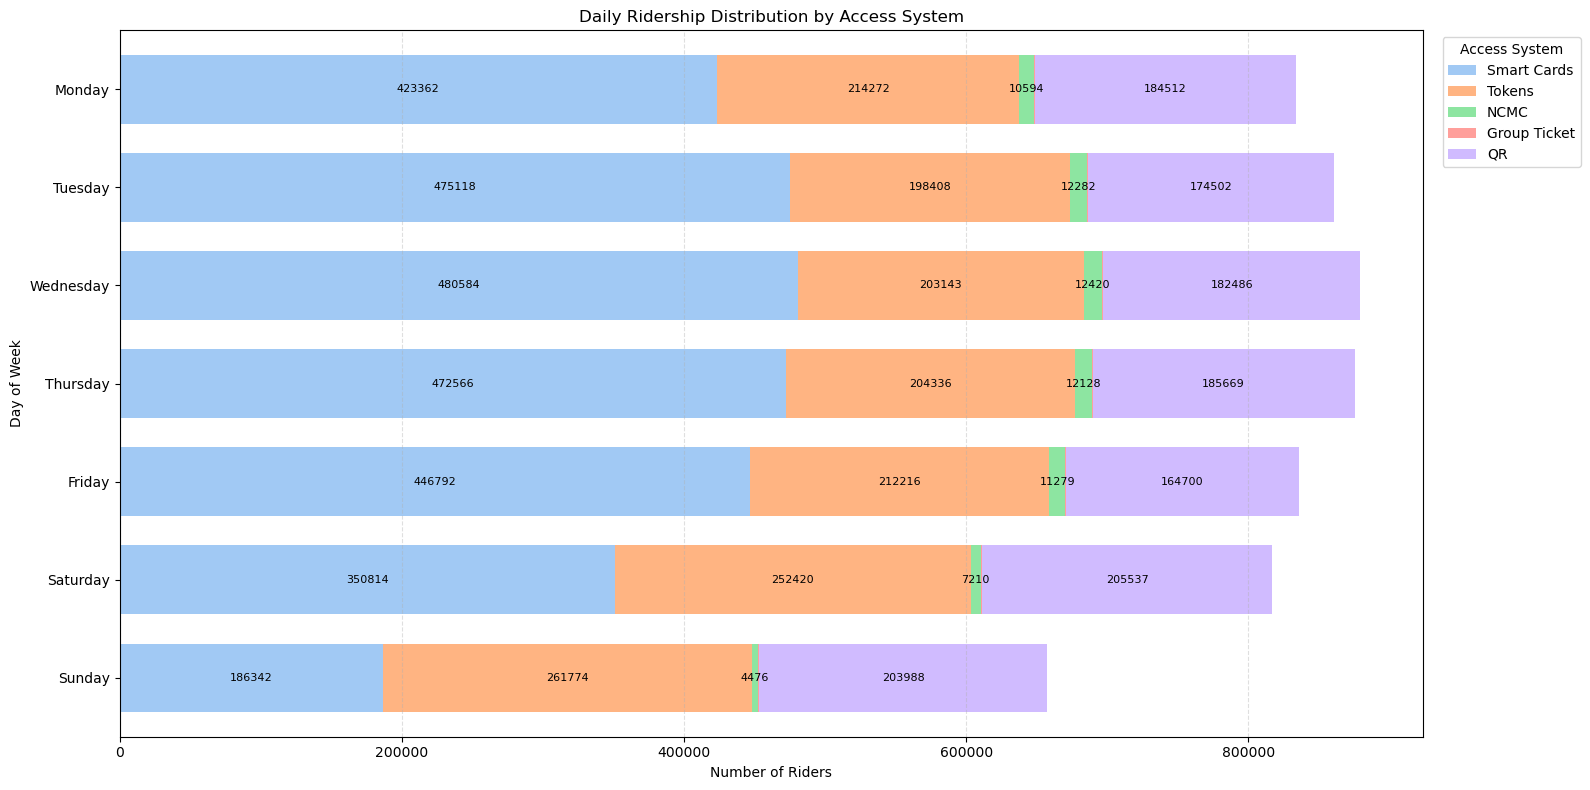

In [436]:
ax = weekly_average.plot(kind='barh', 
                         stacked=True,
                         color=sns.color_palette('pastel', 5),
                         figsize=(16, 8),
                         width=0.7,
                         rot=0)

plt.title('Daily Ridership Distribution by Access System')
plt.ylabel('Day of Week')
plt.xlabel('Number of Riders')
plt.legend(title='Access System', bbox_to_anchor=(1.01, 1), loc='upper left')
plt.grid(axis='x', linestyle='--', alpha=0.4)

# Only show labels for segments larger than 1%
for c in ax.containers:
    labels = ['%.0f' % v if v >= 1000 else '' for v in c.datavalues]
    ax.bar_label(c, labels=labels, label_type='center', fontsize=8)

plt.tight_layout()
plt.show()